# ENISA vulnerabilities 2018 report
## 11. ATT&CK and CAPEC Patterns

In [1]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import utility as util
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import FactorAnalyzer
import plotly.graph_objects as go   
import plotly.figure_factory as ff
import plotly_express as px
import seaborn as sns

In [2]:
data = pd.read_csv('../data/all.csv', low_memory= False)

## 11.1 ATT&CK tactics

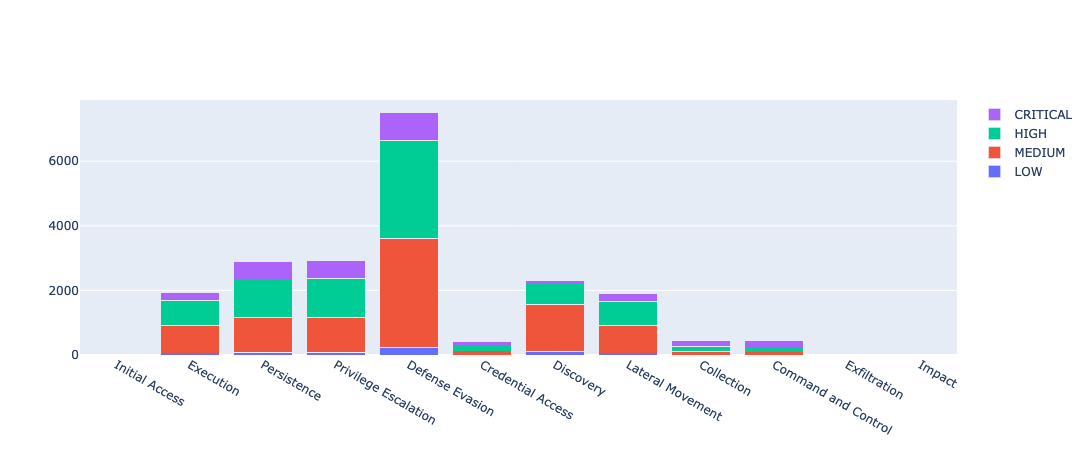

In [4]:
d3=data.copy()[['source_db_id','cvss3_bscore','tactic', 'cvss3_severity']]
df_tactic_stack3 = util.tidy_split(d3, 'tactic', sep=',')
df_tactic_stack3['tactic']=df_tactic_stack3['tactic'].str.strip()
attack_tactic=["Initial Access","Execution","Persistence","Privilege Escalation","Defense Evasion", "Credential Access","Discovery","Lateral Movement","Collection","Command and Control","Exfiltration","Impact"]

fig = go.Figure(data=[
    go.Bar(name='LOW', x=attack_tactic, y=df_tactic_stack3[df_tactic_stack3.cvss3_severity == 'LOW']['tactic'].str.strip().value_counts()[attack_tactic]),
    go.Bar(name='MEDIUM', x=attack_tactic, y=df_tactic_stack3[df_tactic_stack3.cvss3_severity == 'MEDIUM']['tactic'].str.strip().value_counts()[attack_tactic]),
    go.Bar(name='HIGH', x=attack_tactic, y=df_tactic_stack3[df_tactic_stack3.cvss3_severity == 'HIGH']['tactic'].str.strip().value_counts()[attack_tactic]),
    go.Bar(name='CRITICAL', x=attack_tactic, y=df_tactic_stack3[df_tactic_stack3.cvss3_severity == 'CRITICAL']['tactic'].str.strip().value_counts()[attack_tactic])
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

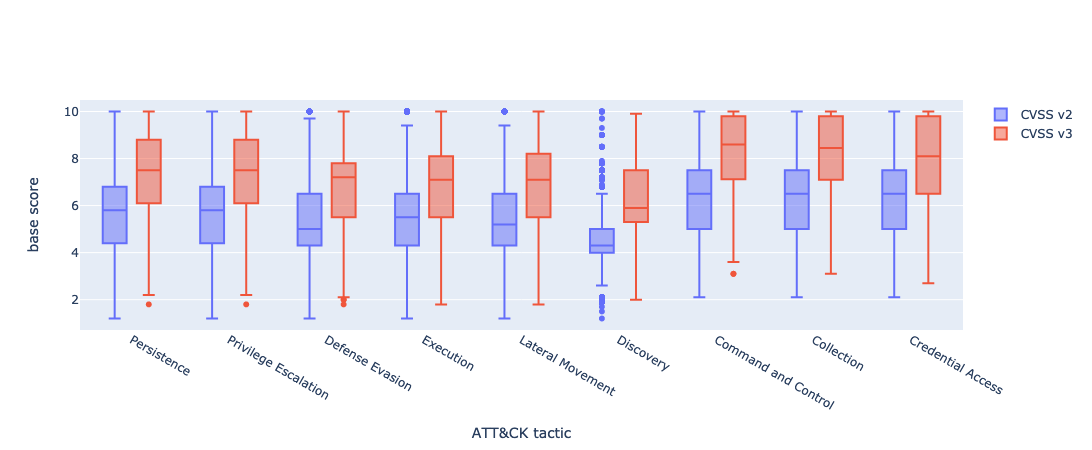

In [5]:
d2=data.copy()[['source_db_id','cvss2_bscore','tactic', 'cvss2_severity']]
df_tactic_stack2 = util.tidy_split(d2, 'tactic', sep=',')
df_tactic_stack2['tactic']=df_tactic_stack2['tactic'].str.strip()


fig=go.Figure()

fig.add_trace(go.Box(
    y=df_tactic_stack2.cvss2_bscore,
    x=df_tactic_stack2.tactic,
    name='CVSS v2',
    #marker_color='#3D9970'
))

fig.add_trace(go.Box(
    y=df_tactic_stack3.cvss3_bscore,
    x=df_tactic_stack3.tactic,
    name='CVSS v3',
    #marker_color='#FF4136'
))

fig.update_layout(
    yaxis_title='base score',
    xaxis_title='ATT&CK tactic',
    boxmode='group' 
)
fig.show()

## 11.2. Hierarchical Clustering on tactics

In [6]:
d3=data.copy()[['source_db_id','tactic']]

df_tactic=pd.DataFrame(d3.tactic.fillna('').str.split(',').values.tolist(),index=d3.source_db_id).stack()
df_tactic = df_tactic.reset_index([0])
df_tactic.columns = ['source_db_id', 'tactic']
df_tactic=df_tactic.reset_index()
df_tactic['tactic']=df_tactic['tactic'].str.strip()
df_tactic=df_tactic[df_tactic.tactic!="None"]
df_tactic=df_tactic[df_tactic.tactic!=""]
df_pivot = df_tactic.pivot_table(index='tactic',columns=['source_db_id'],aggfunc='count', fill_value=0).T
df_pivot

tactic               Collection  Command and Control  Credential Access  \
      source_db_id                                                        
index CVE-2007-6763           0                    0                  0   
      CVE-2009-5150           0                    0                  0   
      CVE-2009-5151           0                    0                  0   
      CVE-2009-5154           0                    0                  1   
      CVE-2009-5158           0                    0                  0   
...                         ...                  ...                ...   
      CVE-2019-9960           0                    0                  0   
      CVE-2019-9970           0                    0                  0   
      CVE-2019-9974           0                    0                  1   
      CVE-2019-9975           0                    0                  1   
      CVE-2019-9977           0                    0                  0   

tactic               Defense Evasion  Discovery  Execution  Lateral Movement  \
      source_db_id                                                             
index CVE-2007-6763                1          0          0                 0   
      CVE-2009-5150                1          0          1                 1   
      CVE-2009-5151                1          0          1                 1   
      CVE-2009-5154                0          0          0                 0   
      CVE-2009-5158                1          0          0                 0   
...                              ...        ...        ...               ...   
      CVE-2019-9960                1          0          1                 1   
      CVE-2019-9970                1          0          0                 0   
      CVE-2019-9974                1          1          0                 0   
      CVE-2019-9975                0          0          0                 0   
      CVE-2019-9977                1          0          0                 0   

tactic               Persistence  Privilege Escalation  
      source_db_id                                      
index CVE-2007-6763            0                     0  
      CVE-2009-5150            1                     1  
      CVE-2009-5151            1                     1  
      CVE-2009-5154            0                     0  
      CVE-2009-5158            0                     0  
...                          ...                   ...  
      CVE-2019-9960            1                     1  
      CVE-2019-9970            0                     0  
      CVE-2019-9974            1                     1  
      CVE-2019-9975            0                     0  
      CVE-2019-9977            0                     0  

[8067 rows x 9 columns]

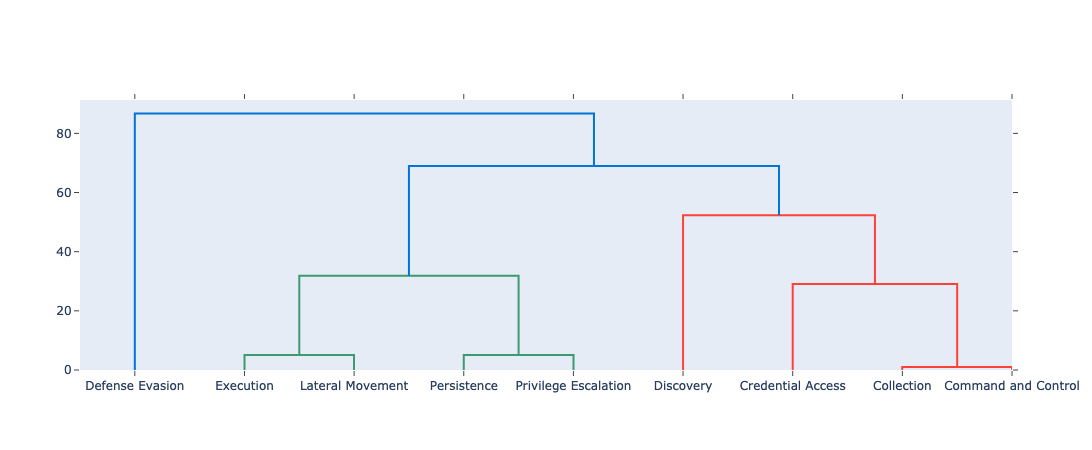

In [7]:
fig = ff.create_dendrogram(df_pivot.T, labels=df_pivot[0:].columns)
fig.show()

#### From the above there are some clear clusters emerging: Collection & Command and Control, which then can be grouped with Credential Access, and further with Discovery. On the other side, Privilege Escallation with Persistence form a cohesive cluster which then can join Execution and Lateral Movement.

#### However, this approach provides a rather qualitative representation. A more quantitative and detailed approach is by factor analysis (see below).

## 11.3. Factor Analysis

In order to decide whether we can perform factor analysis, we need first to check that the correlation matrix is not the identity matrix (through [Bartlett's test for sphericity](https://www.statisticshowto.datasciencecentral.com/bartletts-test/)):

In [8]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_pivot)
chi_square_value, p_value

(134738.3834970662, 0.0)

#### The above p-value is 0 therefore we can proceed with factor analysis.

In [9]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation='varimax')
f=fa.fit(df_pivot)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print('number of factors:',f.n_factors)

number of factors: 3


/opt/anaconda3/envs/enisa/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



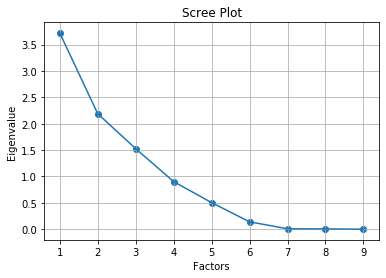

In [10]:
# Confirm graphically the number of factors (i.e. where Eigenvalue>1)
plt.scatter(range(1,df_pivot.shape[1]+1),ev)
plt.plot(range(1,df_pivot.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [11]:
# create correlation matrix and loadings matrix as dataframes
res_correlation=pd.DataFrame(fa.corr_,columns=df_pivot.columns, index=df_pivot.columns)
res_loadings=pd.DataFrame(fa.loadings_,columns=['factor_' + str(i) for i in range(1,fa.n_factors+1)], index=df_pivot.columns)
res_loadings

,factor_1,factor_2,factor_3
tactic,,,
Collection,0.077130,0.993714,0.040203
Command and Control,0.077526,0.993967,0.042662
Credential Access,-0.027146,-0.039032,-0.540420
Defense Evasion,-0.031827,0.007620,0.742956
Discovery,-0.376709,-0.109940,0.010085
Execution,0.938835,-0.218867,0.242702
Lateral Movement,0.931144,-0.217071,0.241626
Persistence,0.919272,0.247243,-0.203042
Privilege Escalation,0.921740,0.259273,-0.223340


#### FINDING:
The reduction of variables shows that are three factors. To establish these factors, for every variable we select the column with the highest number. Therefore:

* __Collection__ (C) & __Command & Control__ (CC) form a latent variable;
* __Credential Access__(CA) & __Defense Evasion__(DE) form another latent variable;
* __Discovery (D), Execution (E), Lateral Movement (LM), Persistence__ (P) & __Privilege Excallation__ (PE) form another latent variable

__However__, we also need to check the internal consistency of the variable. For this we perform Chronbach's alpha for the 3 groups:

In [12]:
# from https://stackoverflow.com/questions/20799403/improving-performance-of-cronbach-alpha-code-python-numpy
# define Chronbach's alpha - this code is not computationally efficient, use with care

def svar(X):
    n = float(len(X))
    svar=(sum([(x-np.mean(X))**2 for x in X]) / n)* n/(n-1.)
    return svar


def CronbachAlpha(itemscores):
    itemvars = [svar(item) for item in itemscores]
    tscores = [0] * len(itemscores[0])
    for item in itemscores:
       for i in range(len(item)):
          tscores[i]+= item[i]
    nitems = len(itemscores)
    #print "total scores=", tscores, 'number of items=', nitems

    Calpha=nitems/(nitems-1.) * (1-sum(itemvars)/ svar(tscores))

    return Calpha

In [13]:
# Perform tests on the three factors
items1=df_pivot[['Collection','Command and Control']].T
itemscores1=np.ndarray.tolist(items1.values)
items2=df_pivot[['Credential Access', 'Defense Evasion']].T
itemscores2=np.ndarray.tolist(items2.values)
items3=df_pivot[['Discovery', 'Execution','Lateral Movement','Persistence','Privilege Escalation']].T
itemscores3=np.ndarray.tolist(items3.values)

print('Factor 1 (Collection, Command & Control):',CronbachAlpha(itemscores1))
print('Factor 2 (Credential Access, Defense Evasion):',CronbachAlpha(itemscores2))
print('Factor 3 (Discovery, Execution, Lateral Movement, Persistence, Privilege Escalation:',CronbachAlpha(itemscores3))

Factor 1 (Collection, Command & Control): 0.9993821750535175
Factor 2 (Credential Access, Defense Evasion): -1.377906860417598
Factor 3 (Discovery, Execution, Lateral Movement, Persistence, Privilege Escalation: 0.7335664823601683


Any factor with Chronbach's Alpha value >.70 is acceptable. Therefore:
* Factor 1 is excellent and accepted
* Factor 2 is not accepted
* Factor 3 is good and accepted

From the above, Factor 2 will need to break into its individual variables.

___
## 11.4. ATT&CK techniques

In [14]:
techniques = util.tidy_split(data,column='technique_id',sep=',')
techniques = techniques[techniques['technique_id']!='nan']


In [15]:
#ATT&CK technique lookups - takes time on slow machine...!
t=techniques
t['techname']=t['technique_id'].map(util.get_name_by_tech)

The ATT&CK framework is constantly enriched with techniques and sub-techniques. At the time of writing, the number of techniques is recorded to 291. In the 2018 dataset, 52 techniques were associated with vulnerabilities, accounting to the 17% of the complete ATT&CK techniques range. The top 3 techniques associated with vulnerabilities are:

* [T1148 – HISTCONTROL](https://attack.mitre.org/techniques/T1148/) (4226 vulnerabilities) 
* [T1027 – Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/) (2293 vulnerabilities) 
* [T1130 – Install Root Certificate](https://attack.mitre.org/techniques/T1130/) (1813 vulnerabilities) 

Out of the 52 techniques, 35 have over 1600 appearances in vulnerabilities, following with a large dip (443 vulnerabilities and below) for the remaining 17:


In [16]:
t.groupby('techname').count()['vendor'].sort_values(ascending=False)

techname
HISTCONTROL                               4226
Obfuscated Files or Information           2293
Install Root Certificate                  1813
Account Discovery                         1779
Permission Groups Discovery               1779
Process Discovery                         1779
Network Service Scanning                  1779
Remote System Discovery                   1779
Network Share Discovery                   1779
Network Share Connection Removal          1779
System Information Discovery              1779
System Network Configuration Discovery    1779
System Network Connections Discovery      1779
System Owner/User Discovery               1779
System Service Discovery                  1779
System Time Discovery                     1779
Peripheral Device Discovery               1779
Login Item                                1676
Launch Agent                              1676
Kernel Modules and Extensions             1676
Disabling Security Tools                  1676
Hype

## 11.5. Critical vulnerabilities with exploits

In [17]:
exploitable_critical=data[(data.n_exploits>0) & (data.cvss3_bscore>=9)]
tech_exp_crit=util.tidy_split(exploitable_critical, column='technique_id', sep=',')
tech_exp_crit = tech_exp_crit[tech_exp_crit['technique_id']!='nan']
tech_exp_crit['techname']=tech_exp_crit['technique_id'].map(util.get_name_by_tech)

In [18]:
# Show techniques for exploitable critical vulnerabilities
tech_exp_crit.groupby('techname').count()['vendor'].sort_values(ascending=False)

techname
HISTCONTROL                               49
Obfuscated Files or Information           35
Hypervisor                                23
Modify Existing Service                   23
Login Item                                23
Launchctl                                 23
Launch Daemon                             23
New Service                               23
Launch Agent                              23
Kernel Modules and Extensions             23
Install Root Certificate                  23
.bash_profile and .bashrc                 23
Logon Scripts                             23
Rootkit                                   23
Service Registry Permissions Weakness     23
Shared Webroot                            23
Disabling Security Tools                  23
Change Default File Association           23
Bootkit                                   23
Accessibility Features                    23
Taint Shared Content                      23
Connection Proxy                          14
A

In [19]:
# run this to display the top n (default 30) critical exploitable vulnerabilitiles with the most techniques

n=30

tech_exp_crit_hist=tech_exp_crit.groupby('source_db_id').count().sort_values(by='techname',ascending=False)['techname']
tech_exp_crit_hist.head(n)

source_db_id
CVE-2014-2048     19
CVE-2018-2697     19
CVE-2018-10661    19
CVE-2018-10662    19
CVE-2018-1164     19
CVE-2018-12596    19
CVE-2018-1383     19
CVE-2018-13859    19
CVE-2018-13861    19
CVE-2018-13862    19
CVE-2018-2943     19
CVE-2017-7821     19
CVE-2018-3245     19
CVE-2018-7072     19
CVE-2018-7520     19
CVE-2019-1619     19
CVE-2019-2517     19
CVE-2019-2699     19
CVE-2019-2725     19
CVE-2019-6814     19
CVE-2018-10285    19
CVE-2018-3110     19
CVE-2016-6598     19
CVE-2015-0150     19
CVE-2017-14097    19
CVE-2017-2741     19
CVE-2018-3813     15
CVE-2018-11741    15
CVE-2019-0285     15
CVE-2018-14328    15
Name: techname, dtype: int64

In [20]:
print('There are {0:d} critical exploitable vulnerabilities with at least one technique registered.\n\n List of CVEs:\n'.format(tech_exp_crit['source_db_id'].nunique()))
mdtext=[ '['+cve+']'+'(https://nvd.nist.gov/vuln/detail/'+cve+')' for cve in tech_exp_crit['source_db_id'].unique()]
md(str(mdtext))

There are 132 critical exploitable vulnerabilities with at least one technique registered.

 List of CVEs:



['[CVE-2016-6598](https://nvd.nist.gov/vuln/detail/CVE-2016-6598)', '[CVE-2017-1204](https://nvd.nist.gov/vuln/detail/CVE-2017-1204)', '[CVE-2017-17976](https://nvd.nist.gov/vuln/detail/CVE-2017-17976)', '[CVE-2017-2750](https://nvd.nist.gov/vuln/detail/CVE-2017-2750)', '[CVE-2017-2741](https://nvd.nist.gov/vuln/detail/CVE-2017-2741)', '[CVE-2018-5955](https://nvd.nist.gov/vuln/detail/CVE-2018-5955)', '[CVE-2017-14097](https://nvd.nist.gov/vuln/detail/CVE-2017-14097)', '[CVE-2018-2697](https://nvd.nist.gov/vuln/detail/CVE-2018-2697)', '[CVE-2018-5726](https://nvd.nist.gov/vuln/detail/CVE-2018-5726)', '[CVE-2018-5724](https://nvd.nist.gov/vuln/detail/CVE-2018-5724)', '[CVE-2018-5723](https://nvd.nist.gov/vuln/detail/CVE-2018-5723)', '[CVE-2017-8046](https://nvd.nist.gov/vuln/detail/CVE-2017-8046)', '[CVE-2018-3813](https://nvd.nist.gov/vuln/detail/CVE-2018-3813)', '[CVE-2018-3810](https://nvd.nist.gov/vuln/detail/CVE-2018-3810)', '[CVE-2018-7316](https://nvd.nist.gov/vuln/detail/CVE-2018-7316)', '[CVE-2018-1164](https://nvd.nist.gov/vuln/detail/CVE-2018-1164)', '[CVE-2018-5767](https://nvd.nist.gov/vuln/detail/CVE-2018-5767)', '[CVE-2017-5817](https://nvd.nist.gov/vuln/detail/CVE-2017-5817)', '[CVE-2017-5816](https://nvd.nist.gov/vuln/detail/CVE-2017-5816)', '[CVE-2017-5815](https://nvd.nist.gov/vuln/detail/CVE-2017-5815)', '[CVE-2018-1383](https://nvd.nist.gov/vuln/detail/CVE-2018-1383)', '[CVE-2018-9161](https://nvd.nist.gov/vuln/detail/CVE-2018-9161)', '[CVE-2018-9032](https://nvd.nist.gov/vuln/detail/CVE-2018-9032)', '[CVE-2014-2048](https://nvd.nist.gov/vuln/detail/CVE-2014-2048)', '[CVE-2018-7520](https://nvd.nist.gov/vuln/detail/CVE-2018-7520)', '[CVE-2017-14004](https://nvd.nist.gov/vuln/detail/CVE-2017-14004)', '[CVE-2018-6223](https://nvd.nist.gov/vuln/detail/CVE-2018-6223)', '[CVE-2018-6220](https://nvd.nist.gov/vuln/detail/CVE-2018-6220)', '[CVE-2018-7702](https://nvd.nist.gov/vuln/detail/CVE-2018-7702)', '[CVE-2018-6328](https://nvd.nist.gov/vuln/detail/CVE-2018-6328)', '[CVE-2018-8096](https://nvd.nist.gov/vuln/detail/CVE-2018-8096)', '[CVE-2018-7750](https://nvd.nist.gov/vuln/detail/CVE-2018-7750)', '[CVE-2018-0147](https://nvd.nist.gov/vuln/detail/CVE-2018-0147)', '[CVE-2018-7753](https://nvd.nist.gov/vuln/detail/CVE-2018-7753)', '[CVE-2017-9269](https://nvd.nist.gov/vuln/detail/CVE-2017-9269)', '[CVE-2018-10575](https://nvd.nist.gov/vuln/detail/CVE-2018-10575)', '[CVE-2018-10285](https://nvd.nist.gov/vuln/detail/CVE-2018-10285)', '[CVE-2018-9059](https://nvd.nist.gov/vuln/detail/CVE-2018-9059)', '[CVE-2016-10430](https://nvd.nist.gov/vuln/detail/CVE-2016-10430)', '[CVE-2015-9208](https://nvd.nist.gov/vuln/detail/CVE-2015-9208)', '[CVE-2015-9147](https://nvd.nist.gov/vuln/detail/CVE-2015-9147)', '[CVE-2015-9146](https://nvd.nist.gov/vuln/detail/CVE-2015-9146)', '[CVE-2018-8733](https://nvd.nist.gov/vuln/detail/CVE-2018-8733)', '[CVE-2015-0150](https://nvd.nist.gov/vuln/detail/CVE-2015-0150)', '[CVE-2018-1273](https://nvd.nist.gov/vuln/detail/CVE-2018-1273)', '[CVE-2018-9126](https://nvd.nist.gov/vuln/detail/CVE-2018-9126)', '[CVE-2018-9035](https://nvd.nist.gov/vuln/detail/CVE-2018-9035)', '[CVE-2018-9248](https://nvd.nist.gov/vuln/detail/CVE-2018-9248)', '[CVE-2018-4108](https://nvd.nist.gov/vuln/detail/CVE-2018-4108)', '[CVE-2018-11523](https://nvd.nist.gov/vuln/detail/CVE-2018-11523)', '[CVE-2018-6411](https://nvd.nist.gov/vuln/detail/CVE-2018-6411)', '[CVE-2018-8898](https://nvd.nist.gov/vuln/detail/CVE-2018-8898)', '[CVE-2018-11094](https://nvd.nist.gov/vuln/detail/CVE-2018-11094)', '[CVE-2018-9112](https://nvd.nist.gov/vuln/detail/CVE-2018-9112)', '[CVE-2018-10561](https://nvd.nist.gov/vuln/detail/CVE-2018-10561)', '[CVE-2016-10036](https://nvd.nist.gov/vuln/detail/CVE-2016-10036)', '[CVE-2018-12908](https://nvd.nist.gov/vuln/detail/CVE-2018-12908)', '[CVE-2018-10662](https://nvd.nist.gov/vuln/detail/CVE-2018-10662)', '[CVE-2018-10661](https://nvd.nist.gov/vuln/detail/CVE-2018-10661)', '[CVE-2018-6667](https://nvd.nist.gov/vuln/detail/CVE-2018-6667)', '[CVE-2018-12634](https://nvd.nist.gov/vuln/detail/CVE-2018-12634)', '[CVE-2018-12557](https://nvd.nist.gov/vuln/detail/CVE-2018-12557)', '[CVE-2015-4664](https://nvd.nist.gov/vuln/detail/CVE-2015-4664)', '[CVE-2018-5488](https://nvd.nist.gov/vuln/detail/CVE-2018-5488)', '[CVE-2017-7821](https://nvd.nist.gov/vuln/detail/CVE-2017-7821)', '[CVE-2018-8859](https://nvd.nist.gov/vuln/detail/CVE-2018-8859)', '[CVE-2016-5649](https://nvd.nist.gov/vuln/detail/CVE-2016-5649)', '[CVE-2018-14328](https://nvd.nist.gov/vuln/detail/CVE-2018-14328)', '[CVE-2018-2943](https://nvd.nist.gov/vuln/detail/CVE-2018-2943)', '[CVE-2018-13862](https://nvd.nist.gov/vuln/detail/CVE-2018-13862)', '[CVE-2018-13861](https://nvd.nist.gov/vuln/detail/CVE-2018-13861)', '[CVE-2018-13859](https://nvd.nist.gov/vuln/detail/CVE-2018-13859)', '[CVE-2018-13981](https://nvd.nist.gov/vuln/detail/CVE-2018-13981)', '[CVE-2016-6567](https://nvd.nist.gov/vuln/detail/CVE-2016-6567)', '[CVE-2016-6548](https://nvd.nist.gov/vuln/detail/CVE-2016-6548)', '[CVE-2018-0040](https://nvd.nist.gov/vuln/detail/CVE-2018-0040)', '[CVE-2018-3753](https://nvd.nist.gov/vuln/detail/CVE-2018-3753)', '[CVE-2018-15534](https://nvd.nist.gov/vuln/detail/CVE-2018-15534)', '[CVE-2018-15152](https://nvd.nist.gov/vuln/detail/CVE-2018-15152)', '[CVE-2018-3110](https://nvd.nist.gov/vuln/detail/CVE-2018-3110)', '[CVE-2018-7072](https://nvd.nist.gov/vuln/detail/CVE-2018-7072)', '[CVE-2017-9000](https://nvd.nist.gov/vuln/detail/CVE-2017-9000)', '[CVE-2018-15137](https://nvd.nist.gov/vuln/detail/CVE-2018-15137)', '[CVE-2018-15961](https://nvd.nist.gov/vuln/detail/CVE-2018-15961)', '[CVE-2018-16763](https://nvd.nist.gov/vuln/detail/CVE-2018-16763)', '[CVE-2018-0645](https://nvd.nist.gov/vuln/detail/CVE-2018-0645)', '[CVE-2018-10824](https://nvd.nist.gov/vuln/detail/CVE-2018-10824)', '[CVE-2018-3245](https://nvd.nist.gov/vuln/detail/CVE-2018-3245)', '[CVE-2018-9206](https://nvd.nist.gov/vuln/detail/CVE-2018-9206)', '[CVE-2018-12596](https://nvd.nist.gov/vuln/detail/CVE-2018-12596)', '[CVE-2018-17440](https://nvd.nist.gov/vuln/detail/CVE-2018-17440)', '[CVE-2018-17456](https://nvd.nist.gov/vuln/detail/CVE-2018-17456)', '[CVE-2018-18793](https://nvd.nist.gov/vuln/detail/CVE-2018-18793)', '[CVE-2018-19126](https://nvd.nist.gov/vuln/detail/CVE-2018-19126)', '[CVE-2018-11741](https://nvd.nist.gov/vuln/detail/CVE-2018-11741)', '[CVE-2019-0006](https://nvd.nist.gov/vuln/detail/CVE-2019-0006)', '[CVE-2019-0002](https://nvd.nist.gov/vuln/detail/CVE-2019-0002)', '[CVE-2019-1663](https://nvd.nist.gov/vuln/detail/CVE-2019-1663)', '[CVE-2019-9082](https://nvd.nist.gov/vuln/detail/CVE-2019-9082)', '[CVE-2019-6139](https://nvd.nist.gov/vuln/detail/CVE-2019-6139)', '[CVE-2019-5420](https://nvd.nist.gov/vuln/detail/CVE-2019-5420)', '[CVE-2014-5432](https://nvd.nist.gov/vuln/detail/CVE-2014-5432)', '[CVE-2019-10041](https://nvd.nist.gov/vuln/detail/CVE-2019-10041)', '[CVE-2019-10011](https://nvd.nist.gov/vuln/detail/CVE-2019-10011)', '[CVE-2019-6716](https://nvd.nist.gov/vuln/detail/CVE-2019-6716)', '[CVE-2018-20526](https://nvd.nist.gov/vuln/detail/CVE-2018-20526)', '[CVE-2018-19524](https://nvd.nist.gov/vuln/detail/CVE-2018-19524)', '[CVE-2019-2725](https://nvd.nist.gov/vuln/detail/CVE-2019-2725)', '[CVE-2019-9791](https://nvd.nist.gov/vuln/detail/CVE-2019-9791)', '[CVE-2019-3801](https://nvd.nist.gov/vuln/detail/CVE-2019-3801)', '[CVE-2019-2699](https://nvd.nist.gov/vuln/detail/CVE-2019-2699)', '[CVE-2019-2517](https://nvd.nist.gov/vuln/detail/CVE-2019-2517)', '[CVE-2019-3899](https://nvd.nist.gov/vuln/detail/CVE-2019-3899)', '[CVE-2019-1710](https://nvd.nist.gov/vuln/detail/CVE-2019-1710)', '[CVE-2019-0285](https://nvd.nist.gov/vuln/detail/CVE-2019-0285)', '[CVE-2019-0040](https://nvd.nist.gov/vuln/detail/CVE-2019-0040)', '[CVE-2019-6814](https://nvd.nist.gov/vuln/detail/CVE-2019-6814)', '[CVE-2019-0708](https://nvd.nist.gov/vuln/detail/CVE-2019-0708)', '[CVE-2019-1821](https://nvd.nist.gov/vuln/detail/CVE-2019-1821)', '[CVE-2019-1619](https://nvd.nist.gov/vuln/detail/CVE-2019-1619)', '[CVE-2019-10149](https://nvd.nist.gov/vuln/detail/CVE-2019-10149)', '[CVE-2019-11367](https://nvd.nist.gov/vuln/detail/CVE-2019-11367)', '[CVE-2017-14728](https://nvd.nist.gov/vuln/detail/CVE-2017-14728)', '[CVE-2019-9848](https://nvd.nist.gov/vuln/detail/CVE-2019-9848)', '[CVE-2019-13360](https://nvd.nist.gov/vuln/detail/CVE-2019-13360)', '[CVE-2017-8226](https://nvd.nist.gov/vuln/detail/CVE-2017-8226)', '[CVE-2018-11686](https://nvd.nist.gov/vuln/detail/CVE-2018-11686)', '[CVE-2019-15657](https://nvd.nist.gov/vuln/detail/CVE-2019-15657)', '[CVE-2019-1937](https://nvd.nist.gov/vuln/detail/CVE-2019-1937)', '[CVE-2019-1935](https://nvd.nist.gov/vuln/detail/CVE-2019-1935)', '[CVE-2019-9851](https://nvd.nist.gov/vuln/detail/CVE-2019-9851)', '[CVE-2019-13101](https://nvd.nist.gov/vuln/detail/CVE-2019-13101)']

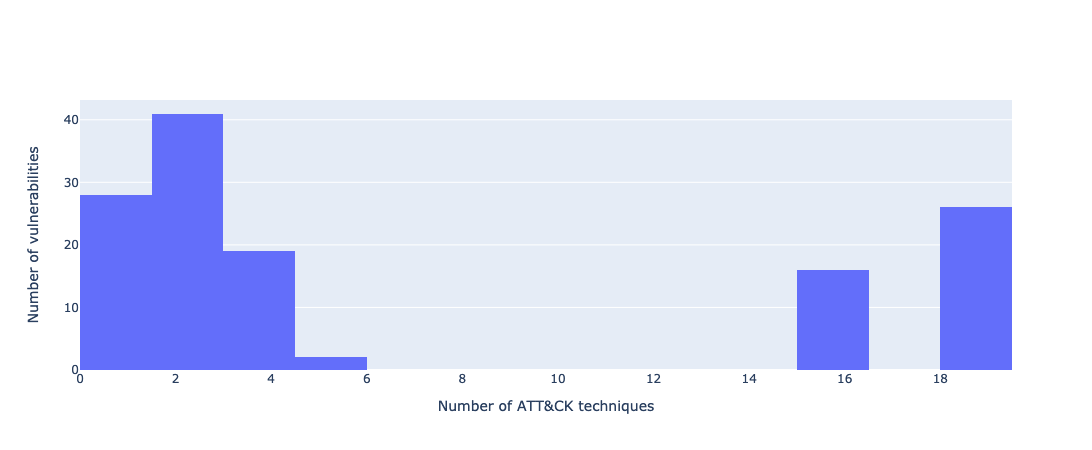

In [21]:
fig=go.Figure(data=[go.Histogram(x=tech_exp_crit_hist, xbins=dict(
        start=0,
        end=20,
        size=1.5))])
fig.update_layout(xaxis_title='Number of ATT&CK techniques', yaxis_title='Number of vulnerabilities')

___
## 11.6. CAPEC Patterns

In [22]:
# split dataset rows to distinct CAPEC id on vulnerabilities having also an exploit
#capec=util.explode_capec(data[data.n_exploits>0])

capec = util.tidy_split(data[data.n_exploits>0],column='capec',sep=',')
capec = capec[capec['capec']!='nan']

capec.shape

(31436, 59)

In [23]:
# create lookups between CAPEC id and name - takes time on slow machine!
capec['name']=capec['capec'].apply(util.get_name_by_capec)

In [24]:
# Select only CAPEC patterns appearing in critical vulnerabilities

capec_critical=capec[capec.cvss3_bscore>8.9]

In [25]:
# Get the CAPEC patterns of the top n critical vulnerabilities based on the average CVSS score

n=20

top_capec_cvss3=capec_critical.groupby('capec').mean().sort_values(by='cvss3_bscore',ascending=False).head(n)
top_capec_cvss3=top_capec_cvss3.reset_index()

# Get the CAPEC patterns of the top n critical vulnerabilities based on total count

top_capec=capec_critical.groupby('capec').count().sort_values(by='cvss3_bscore',ascending=False).head(n)
top_capec=top_capec.reset_index()


In [26]:
critical_capec_id=capec_critical.capec[capec_critical.name.isin(top_capec_cvss3.index)]
capec[capec.capec.isin(top_capec_cvss3.capec)].groupby('capec').count()

,Unnamed: 0,id,source_db,source_db_id,cna,cvss3_bscore,cvss3_severity,cvss3_impact,cvss3_exploitability,cvss3_attack,...,EOS_version,EOS_date,Type,0day,Today,0day_low_y,0day_upper,Today_low,Today_upper,name
capec,,,,,,,,,,,,,,,,,,,,,
111,96,96,96,96,96,96,96,96,96,96,...,0,0,6,6,6,6,6,6,6,96
112,7,7,7,7,7,7,7,7,7,7,...,0,0,0,0,0,0,0,0,0,7
12,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,2
128,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
129,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
166,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,2
192,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,6
196,5,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,5
20,11,11,11,11,11,11,11,11,11,11,...,0,0,1,1,1,1,1,1,1,11


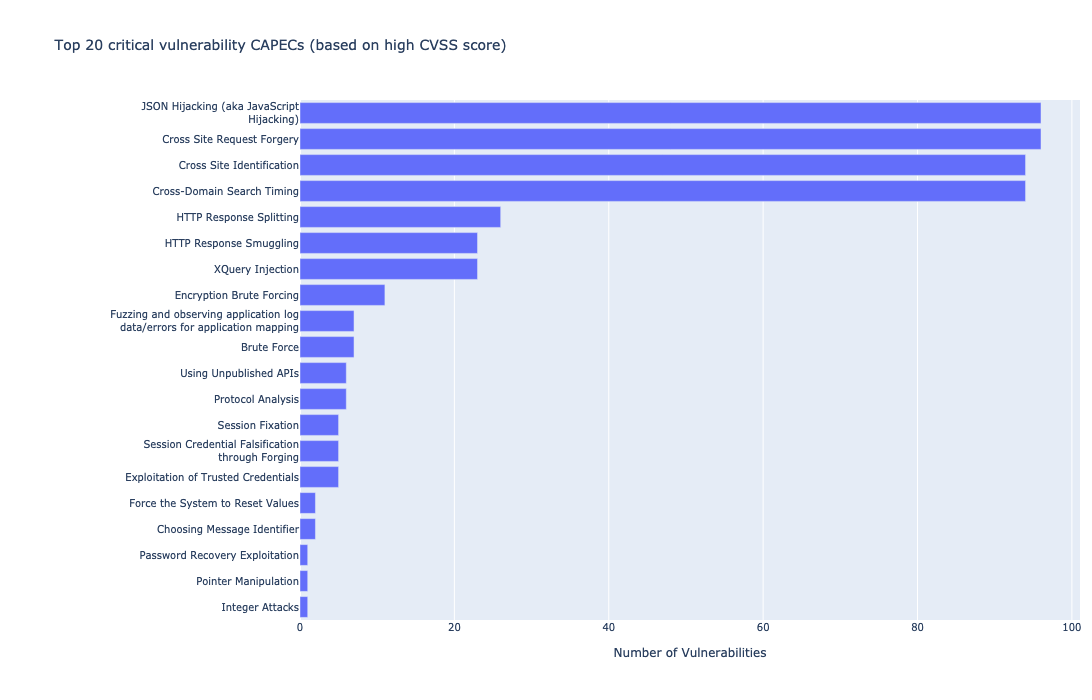

In [27]:
c=capec[capec.capec.isin(top_capec_cvss3.capec)].groupby('capec').count().sort_values(by='source_db_id',ascending=True)['source_db_id']
c=c.reset_index()
c['name']=c['capec'].apply(util.get_name_by_capec)
c['name']=c['name'].map(util.wrap)

fig = go.Figure()
fig.add_bar(x=c.source_db_id, y=c.name, orientation='h')

fig.update_layout(title='Top {0:d} critical vulnerability CAPECs (based on high CVSS score)'.format(n),
                  xaxis = dict(title='Number of Vulnerabilities'),
                  margin = dict(l = 300, r=10),
                  font=dict(size=10), height=700)

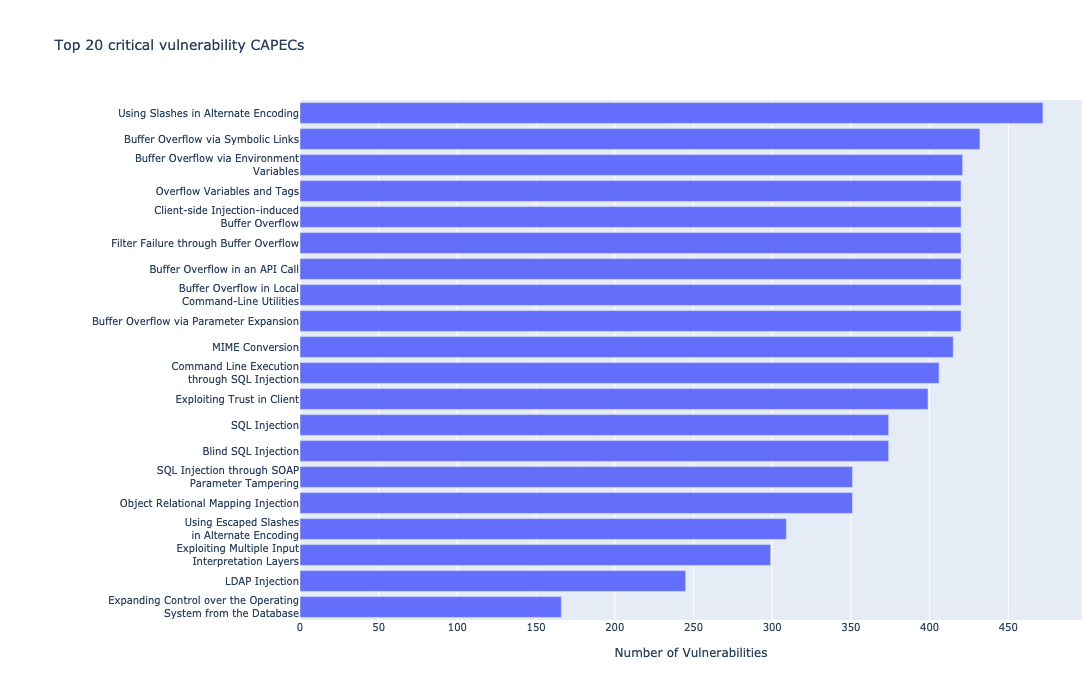

In [28]:
critical_capec_id=capec_critical.capec[capec_critical.name.isin(top_capec.index)]
c=capec[capec.capec.isin(top_capec.capec)].groupby('capec').count().sort_values(by='source_db_id',ascending=True)['source_db_id']
c=c.reset_index()
c['name']=c['capec'].apply(util.get_name_by_capec)
c['name']=c['name'].map(util.wrap)

fig = go.Figure()
fig.add_bar(x=c.source_db_id, y=c.name, orientation='h')

fig.update_layout(title='Top {0:d} critical vulnerability CAPECs'.format(n),
                  xaxis = dict(title='Number of Vulnerabilities'),
                  margin = dict(l = 300, r=10),
                  font=dict(size=10), height=700)